In [ ]:
#this will take the extended train2 data set and create the following features, the data will then be split into train and test

#average sales last 3 6 9 months
#trend of sales in last 3 and 6 months - gradient of line
    
# std in price in last month, m-2
#days since first sale
#consistency of sales - continuous or stacatto- is there something every day or everynow and then?
# total sales for this shop in the last month, m-2
# total sales for this product in the last month
    #calculate same variables for the half month as that's all here

In [49]:
#load the data, add a few key variables, reduce to a specific product
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
dateCols = ['date']
train2=pd.read_csv("/home/cdsw/train_plus_not_imputted.csv",parse_dates=dateCols)
train2["TotalRevenue"]=train2.item_cnt_day*train2.item_price
train2["Month"]=train2.date.dt.month
train2["Year"]=train2.date.dt.year
train2['YM'] = train2['Year']*100+train2["Month"]

#create an average per month - see how it changes
sales_per_item_PM= train2.groupby(['item_id', "shop_id",'YM'])['item_cnt_day',"TotalRevenue" ].sum().reset_index()
sales_per_item_PM["AvPrice"]=sales_per_item_PM.TotalRevenue/sales_per_item_PM.item_cnt_day
sales_per_item_PM["id"]=sales_per_item_PM.item_id.astype("str")+"_"+sales_per_item_PM.shop_id.astype("str")

#pivot the data to get to get into a format required for predicting
sales_perM= sales_per_item_PM.pivot_table(index=["id"],columns="YM",values="item_cnt_day", fill_value=0).reset_index() 

In [50]:
#drop 201511 and 201512

sales=sales_perM.drop([sales_perM.columns[35],sales_perM.columns[36]],axis="columns")

#rename columns so sep= sales_minus1
df = pd.DataFrame({'M': range(1,34)})
df["Txt"]="SlsMth_min"+df.M.astype("str")
df2=df.sort_values(["M"],ascending=False)
nms2=list(df2.Txt)
nms1=[]
nms1.extend('i')
nms1.extend(nms2)
nms1.extend('T')
sales.columns=nms1
sales.rename(columns={'i': 'ids', 'T': 'Target'}, inplace=True)

#average of sales 3,6, 9 months prior
sales["Sls_Av3"]=  sales[["SlsMth_min3","SlsMth_min2","SlsMth_min1"]].mean(axis=1)
sales["Sls_Av6"]=sales.loc[: , "SlsMth_min6":"SlsMth_min1"].mean(axis=1)
sales["Sls_Av9"]=sales.loc[: , "SlsMth_min9":"SlsMth_min1"].mean(axis=1)

#sales trends of last 3,6,9 months
sales['STrend3'] = np.where(sales.SlsMth_min1==0, 0, (sales.SlsMth_min3-sales.SlsMth_min1)/sales.SlsMth_min1)
sales['STrend6'] = np.where(sales.SlsMth_min1==0, 0, (sales.SlsMth_min6-sales.SlsMth_min1)/sales.SlsMth_min1)
sales['STrend9'] = np.where(sales.SlsMth_min1==0, 0, (sales.SlsMth_min9-sales.SlsMth_min1)/sales.SlsMth_min1)

#variance of sales in last 3, 6, 9 months
sales["SVar3"]=sales.loc[:,"SlsMth_min3":"SlsMth_min1"].var(axis=1)
sales["SVar6"]=sales.loc[:,"SlsMth_min6":"SlsMth_min1"].var(axis=1)
sales["SVar9"]=sales.loc[:,"SlsMth_min9":"SlsMth_min1"].var(axis=1)
sales.head()



,ids,SlsMth_min33,SlsMth_min32,SlsMth_min31,SlsMth_min30,SlsMth_min29,SlsMth_min28,SlsMth_min27,SlsMth_min26,SlsMth_min25,...,Target,Sls_Av3,Sls_Av6,Sls_Av9,STrend3,STrend6,STrend9,SVar3,SVar6,SVar9
0,0_54,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000_25,1,0,0,0,0,0,1,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000_26,0,0,0,0,0,0,1,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000_29,0,0,0,0,0,0,0,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10000_30,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
#other features require cuts of the original data and then merging

#standard dev of price in the last months
stdprice= train2.groupby(['item_id', "shop_id",'YM'])['item_price'].std().reset_index()
#set value to 0 where NaN
stdprice["item_price"]=stdprice.item_price.fillna(0)
stdprice["ids"]=stdprice.item_id.astype("str")+"_"+stdprice.shop_id.astype("str")
stdprice2=stdprice.loc[stdprice.YM.isin([201508,201509,201510])]
stdprice3=stdprice2.pivot_table(index=["ids"],columns="YM", values="item_price", fill_value=0).reset_index()
stdprice3.rename(columns={201508:"PStd1508",201509:"PStd1509",201510:"PStd1510"},inplace=True)

#merge to dataset
s1=pd.merge(sales, stdprice3, how="left", on="ids")


In [52]:
#only 71k combinations sold in comparison to the 400k plus historically
print("Number of shop product combos in the last 3 months:", stdprice3.shape)
print("Vs number of shop product combos in ALL months:", sales.shape)

Number of shop product combos in the last 3 months: (71461, 4)
Vs number of shop product combos in ALL months: (424124, 44)


In [53]:
#total sales for this shop over last couple of months
#groupby YM, shop,sales
shops= train2.groupby(["YM","shop_id"])["item_cnt_day"].sum().reset_index()
#filter
shops2=shops.loc[shops.YM.isin([201508,201509])]
#pivot
shops3=shops2.pivot_table(index=["shop_id"],columns="YM",values="item_cnt_day",fill_value=0).reset_index()
shops3.columns=["shop_id","ShopSales_1508","ShopSales_1509"]

In [54]:
#merge this to the dataset
#split the tuple to get the lookup value
s1['shop_id'] = s1['ids'].str.split('_').str[1].astype("int64")
s1["item_id"]=s1["ids"].str.split("_").str[0].astype("int64")
#merge to the shop id
s2=pd.merge(s1, shops3,how="left", on="shop_id")

In [55]:
#total sales for this product over last couple of months
#groupby YM and prod
prods=train2.groupby(["YM","item_id"])["item_cnt_day"].sum().reset_index()
#filter
prods2=prods.loc[prods.YM.isin([201508,201509])]
#pivot
prods3=prods2.pivot_table(index=["item_id"],columns="YM",values="item_cnt_day", fill_value=0).reset_index()
#rename
prods3.columns=["item_id","ProdSales1508","ProdSales1509"]

In [56]:
#merge to the data set
s3=pd.merge(s2,prods3, how="left",on="item_id")

In [57]:
#consistency of sales - continuous or stacatto- is there something every day or everynow and then?
#do a count of number of days where occurs
#group by YM item id and date
consistency=train2.groupby(["YM","date", "item_id"])["item_cnt_day"].sum().reset_index()
#filter to last 3 months
consistency2=consistency.loc[consistency.YM.isin([201507,201508,201509])]
#group by date and item id - count!
consistency3=consistency2.groupby(["YM","item_id"])["date"].count().reset_index()
#pivot
consistency4=consistency3.pivot_table(index=["item_id"],columns="YM",values="date",fill_value=0).reset_index()
#rename
consistency4.columns=["item_id","DaysSold1507","DaysSold1508","DaysSold1509"]

In [58]:
#merge
s4=pd.merge(s3,consistency4,how="left",on="item_id")

In [59]:
#days since first sale
import datetime as dt
#sort consistency by date
firstsale=consistency.sort_values("date")
#drop_duplicates
firstsale2=firstsale.drop_duplicates(subset=["item_id"],keep="first")
firstsale3=firstsale2.drop(["YM","item_cnt_day"],axis=1)
#calculate the number days since sales began

firstsale3["D_Since_FirstSale"]= (dt.datetime.strptime("2015-10-01", "%Y-%m-%d")-firstsale3.date).dt.days

s5=pd.merge(s4,firstsale3[["item_id","D_Since_FirstSale"]],how="left",on="item_id")

In [60]:
#Na's introduced - go through and understand why
#in shop sales some shops didn't sell any - set to zero
s5["ShopSales_1508"]=s5["ShopSales_1508"].fillna(0)
s5["ShopSales_1509"]=s5["ShopSales_1509"].fillna(0)
s5["ProdSales1508"]=s5["ProdSales1508"].fillna(0)
s5["ProdSales1509"]=s5["ProdSales1508"].fillna(0)
s5["DaysSold1507"]=s5["DaysSold1507"].fillna(0)
s5["DaysSold1508"]=s5["DaysSold1508"].fillna(0)
s5["DaysSold1509"]=s5["DaysSold1509"].fillna(0)
s5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424124 entries, 0 to 424123
Data columns (total 57 columns):
ids                  424124 non-null object
SlsMth_min33         424124 non-null int64
SlsMth_min32         424124 non-null int64
SlsMth_min31         424124 non-null int64
SlsMth_min30         424124 non-null int64
SlsMth_min29         424124 non-null int64
SlsMth_min28         424124 non-null int64
SlsMth_min27         424124 non-null int64
SlsMth_min26         424124 non-null int64
SlsMth_min25         424124 non-null int64
SlsMth_min24         424124 non-null int64
SlsMth_min23         424124 non-null int64
SlsMth_min22         424124 non-null int64
SlsMth_min21         424124 non-null int64
SlsMth_min20         424124 non-null int64
SlsMth_min19         424124 non-null int64
SlsMth_min18         424124 non-null int64
SlsMth_min17         424124 non-null int64
SlsMth_min16         424124 non-null int64
SlsMth_min15         424124 non-null int64
SlsMth_min14         424124 

In [64]:
#how many old product combinations that no longer sell
zeros=s5[s5.PStd1508.isnull()]
print("Number of old product and shop combinations:",zeros[zeros.D_Since_FirstSale<0].shape)
print("Number of new product and combinations", zeros[zeros.D_Since_FirstSale>0].shape)



Number of old product and shop combinations: (39, 57)
Number of new product and combinations (352624, 57)


In [152]:
#reduce the data set to those which have had any sales in the last 3 months
#predict 0 sales for those not here
    #exception will be for new products - look at seperately
endtrain=s5[s5.PStd1508.notnull()]
endtrain.to_csv("/home/cdsw/all_data_with_features.csv")

In [2]:
y=endtrain[["Target"]]
X=endtrain.drop("Target", axis=1)
print(y.shape)
print(X.shape)
print(endtrain.shape)

(71461, 1)
(71461, 57)
(71461, 58)


In [6]:
#This shows that I cannot stratify the data.  Continuous rather than classes to predict.
y.groupby(["Target"])["Target"].count()

Target
-2           1
-1          44
 0       37407
 1       24380
 2        5286
 3        1853
 4         889
 5         469
 6         274
 7         183
 8         109
 9          95
 10         64
 11         35
 12         44
 13         37
 14         23
 15         14
 16         27
 17         18
 18         14
 19         22
 20          9
 21         11
 22         11
 23          9
 24          3
 25          7
 26         11
 27          8
         ...  
 67          1
 68          1
 69          1
 70          1
 72          1
 74          1
 78          2
 79          1
 83          1
 87          1
 95          1
 97          1
 98          1
 99          1
 102         1
 103         1
 106         1
 115         2
 116         1
 120         1
 131         1
 152         1
 166         1
 190         1
 238         1
 384         1
 388         1
 446         1
 500         1
 2246        1
Name: Target, Length: 93, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test,Y_train, Y_test = train_test_split(X,y,test_size=0.3, 
                                                   random_state=428)

In [9]:
print(endtrain.shape)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(71461, 58)
(50022, 57)
(21439, 57)
(50022, 1)
(21439, 1)


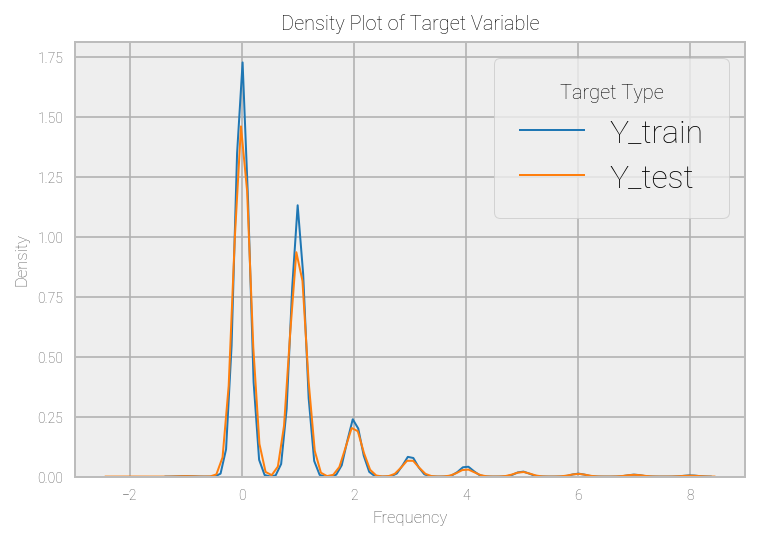

In [48]:
import seaborn as sns
from matplotlib import pyplot as plt

# Draw the density plot
sns.distplot(Y_train, hist = False, kde = True, kde_kws = {'linewidth': 1}, label = "Y_train")
sns.distplot(Y_test, hist = False, kde = True, kde_kws = {'linewidth': 1}, label = "Y_test")
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Target Type')
plt.title('Density Plot of Target Variable')
plt.xlabel('Frequency')
plt.ylabel('Density')



In [ ]:
#This shows that the classes are imbalanced - and its because of the predominance of the low values and skew of outliers
# therefore, create 2 splits of the data based on the volumes and stratify the smaller element, and then concat the data together

In [22]:
end_small=endtrain[endtrain.Target <9]
end_big=endtrain[endtrain.Target>=9]
y1=end_small[["Target"]]
X1=end_small.drop("Target", axis=1)
y2=end_big[["Target"]]
X2=end_big.drop("Target", axis=1)

print(y1.shape)
print(X1.shape)
print(y2.shape)
print(X2.shape)

print(endtrain.shape)

(70895, 1)
(70895, 57)
(566, 1)
(566, 57)
(71461, 58)


In [44]:
X_train1, X_test1,Y_train1, Y_test1 = train_test_split(X1,y1,test_size=0.3, 
                                                   random_state=428)

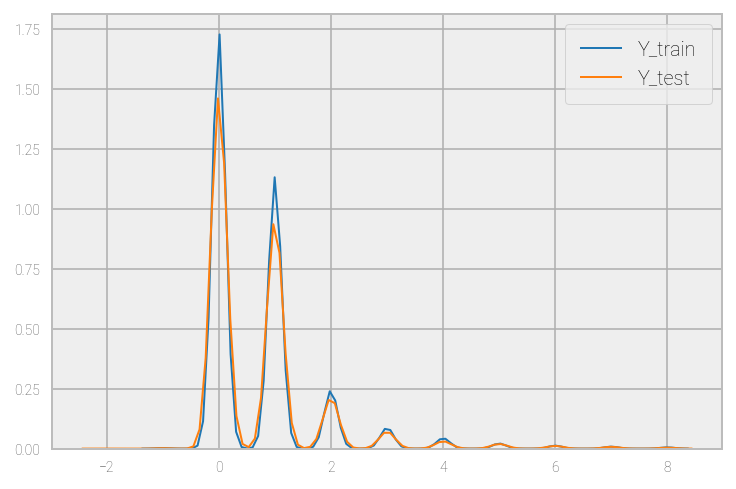

In [45]:

# Draw the density plot
sns.distplot(Y_train1, hist = False, kde = True, kde_kws = {'linewidth': 1}, label = "Y_train")
sns.distplot(Y_test1, hist = False, kde = True, kde_kws = {'linewidth': 1}, label = "Y_test")

In [46]:
#review the proportions
check3=Y_train1.groupby(["Target"])["Target"].count().reset_index(name ='Count_Train1')
#check1.columns=["Target","Count_Train2"]
check3["Prop_CountTrain1"]=check3.Count_Train1/sum(check3.Count_Train1)
check3

,Target,Count_Train1,Prop_CountTrain1
0,-1,31,0.000625
1,0,26172,0.527385
2,1,17077,0.344114
3,2,3669,0.073933
4,3,1311,0.026418
5,4,656,0.013219
6,5,320,0.006448
7,6,187,0.003768
8,7,125,0.002519
9,8,78,0.001572


In [47]:
check4=Y_test1.groupby(["Target"])["Target"].count().reset_index(name="Count_Test2")
check4["Prop_CountTest2"]=check4.Count_Test2/sum(check4.Count_Test2)
check4

,Target,Count_Test2,Prop_CountTest2
0,-2,1,0.000047
1,-1,13,0.000611
2,0,11235,0.528234
3,1,7303,0.343364
4,2,1617,0.076026
5,3,542,0.025483
6,4,233,0.010955
7,5,149,0.007006
8,6,87,0.004090
9,7,58,0.002727


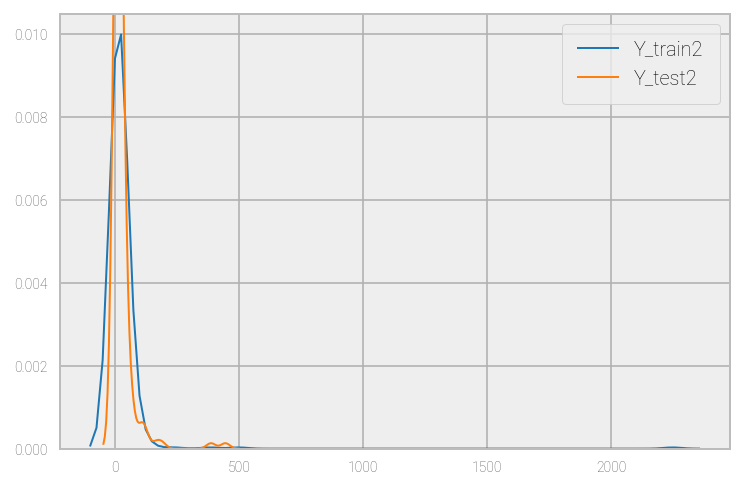

In [29]:
X_train2, X_test2,Y_train2, Y_test2 = train_test_split(X2,y2,test_size=0.3, 
                                                   random_state=428)
# Draw the density plot
sns.distplot(Y_train2, hist = False, kde = True, kde_kws = {'linewidth': 1}, label = "Y_train2")
sns.distplot(Y_test2, hist = False, kde = True, kde_kws = {'linewidth': 1}, label = "Y_test2")

In [41]:
check1=Y_train2.groupby(["Target"])["Target"].count().reset_index(name ='Count_Train2')
#check1.columns=["Target","Count_Train2"]
check1["Prop_CountTrain2"]=check1.Count_Train2/sum(check1.Count_Train2)
check1.head(10)

,Target,Count_Train2,Prop_CountTrain2
0,9,66,0.166667
1,10,42,0.106061
2,11,26,0.065657
3,12,29,0.073232
4,13,26,0.065657
5,14,16,0.040404
6,15,14,0.035354
7,16,18,0.045455
8,17,15,0.037879
9,18,10,0.025253


In [43]:
check2=Y_test2.groupby(["Target"])["Target"].count().reset_index(name="Count_Test2")
check2["Prop_CountTest2"]=check2.Count_Test2/sum(check2.Count_Test2)
check2.head(10)

,Target,Count_Test2,Prop_CountTest2
0,9,29,0.170588
1,10,22,0.129412
2,11,9,0.052941
3,12,15,0.088235
4,13,11,0.064706
5,14,7,0.041176
6,16,9,0.052941
7,17,3,0.017647
8,18,4,0.023529
9,19,7,0.041176


In [ ]:
#proportions stack therefore add together and use these as the test and train sets